In [69]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import re

## List of data sources:
1. **Minneapolis Police Incidents Minneapolis police incidents**: https://opendata.minneapolismn.gov/
2. **Local Climatological Data (for weather)**: https://www.ncei.noaa.gov/products/land-based-station/local-climatological-data
3. **Hennepin County Police Stations**: https://gis-hennepin.hub.arcgis.com/datasets/hennepin::police-stations/explore

Our primary dataset was the Minneapolis Police Incidents from 2017 to 2023 which also came with separate geojson files for locations of the crime. Secondary datasets were the weather data and Hennepin county police stations

# Introduction
This notebook combines crime records in Minneapolis neghborhoods from 2017 to 2023. Each annual record has complementary geospatial data. Weather data was also collected to potentially analyze the relationship between crime and weather. The scope of this notebook is to combine all of the disparate sources of data into one file and to create meaningful features to set up premises for future analysis with this data.

# Outline of this notebook
1. Read in each year's crime data, preprocess them and combine them into one.
2. Discuss data quality of the crime data.
3. Scrape weather data.
4. Create new features
5. Read in each year's geospatial crime data and combined them into one.

## 1. Read in each year's crime data and combine

The data are from 2017 to 2023. We observed differences in the structures of data. For instance, 2017 and 2018 data had similar structures (with small variance) and 2019 through 2023 data had similar structures. We wanted to match the column names before we row-bind each year's data. However, We encountered some data quality issues with 2018 date time columns. Years 2017, 2019 and 2023 have date format of `YYYY/mm/dd HH:MM:SS+00`
but 2018 data file have datetime format of `YYYY/mm/dd HH:MM:SS`. We need to add +00 at the end. for 2018 data.

- 2017 and 2018 data columns (2018 data has `FID` instaed of `OBJECTID`):

| col name       | example                |
|----------------|------------------------|
| OBJECTID       | 1                      |
| PublicAddress  | 0026XX Emerson AV N    |
| ControlNbr     | 3696102                |
| CCN            | MP 2017 292070         |
| Precinct       | 4                      |
| ReportedDate   | 2017/08/02 19:30:00+00 |
| BeginDate      | 2017/07/28 15:00:00+00 |
| Time           | 15:00:00               |
| Offense        | AUTOTH                 |
| Description    | Motor Vehicle Theft    |
| UCRCode        | 8                      |
| EnteredDate    | 2017/08/02 19:15:05+00 |
| GBSID          | 20359                  |
| Lat            | 45.0068497             |
| Long           | -93.29431515           |
| X              | -10385475.66           |
| Y              | 5622599.896            |
| Neighborhood   | HAWTHORNE              |
| LastChanged    | 2017/08/07 06:28:36+00 |
| LastUpdateDate | 2017/08/07 20:00:32+00 |



- 2019 - 2023 data structure:


| col name          | example                        |
|-------------------|--------------------------------|
| X                 | -93.29739573                   |
| Y                 | 44.954203                      |
| publicaddress     | 0026XX HENNEPIN AVE            |
| caseNumber        | MP20191000                     |
| precinct          | 5                              |
| reportedDate      | 2019/01/01 00:00:00+00         |
| reportedTime      | 2323                           |
| beginDate         | 2019/01/01 00:00:00+00         |
| reportedDateTime  | 2019/01/01 23:23:00+00         |
| beginTime         | 2230                           |
| offense           | TFMV                           |
| description       | THEFT FROM MOTR VEHC           |
| UCRCode           | 7                              |
| enteredDate       | 2019/01/02 00:00:00+00         |
| centergbsid       | 17300                          |
| centerLong        | -93.29739                      |
| centerLat         | 44.9542                        |
| centerX           | -10385818.59                   |
| centerY           | 5614314.565                    |
| neighborhood      | East Isles                     |
| lastchanged       | 2019/01/02 00:00:00+00         |
| LastUpdated       | 2022/03/17 09:10:30+00         |
| OBJECTID          | 1                              |


Combined data structure:

1. Case number (as a unique ID)
2. Public address
3. Reported date and time in a format YYYY/mm/dd HH:MM:SS+offset
4. Begin date and time in a format YYYY/mm/dd HH:MM:SS+offset
5. Longitude
6. Latitude
7. Precinct number
8. Neighborhood name
9. Offense code
10. Description of the offense

In [70]:
!pwd

/c/Users/mcho1/Desktop/umn/ST THOMAS/SEIS 732/SEIS 732 project


In [71]:
# read police incidents data
pattern = re.compile("^Police_Incidents.+csv$")
df_dict = {"file name": [], "data frame": []}

# for root, dirs, files in os.walk("data"):
for _, _, files in os.walk("data/mpls"):
    for file in files:
        file_match = re.match(pattern, file)
        if file_match:
            # print(file_match.group())
            # display(pd.read_csv(f"data/st_paul/{file_match.group()}"))
            file_name = file_match.group()
            df = pd.read_csv(f"data/mpls/{file_name}")
            df_dict["file name"].append(file_name)
            df_dict["data frame"].append(df)

display(pd.DataFrame(df_dict))

,file name,data frame
0,Police_Incidents_2017.csv,OBJECTID PublicAddress Contro...
1,Police_Incidents_2018.csv,FID PublicAddress ControlNb...
2,Police_Incidents_2019.csv,X Y publicaddr...
3,Police_Incidents_2020.csv,X Y publicaddre...
4,Police_Incidents_2021.csv,X Y publica...
5,Police_Incidents_2022.csv,X Y OBJECTID ...
6,Police_Incidents_2023.csv,X Y publi...


In [72]:
# subset only necessary columns for 2017 and 2018
cols_17 = ["CCN", "PublicAddress", "ReportedDate", "BeginDate", "Long", "Lat", "Precinct", "Neighborhood","Offense", "Description"]
cols_19 = ["caseNumber", "publicaddress", "reportedDateTime", "beginDate", "beginTime",
            "centerLong", "centerLat", "precinct", "neighborhood", "offense", "description"]

for i, df in enumerate(df_dict["data frame"]):
    if set(cols_17).issubset(df.columns):
        # for 2018 data only, 2018 data has column FID
        if "FID" in df.columns:
            for col in ["ReportedDate", "BeginDate"]:
                df_dict["data frame"][i][col] = df[col] + "+00"
                
        # subset columns
        df_dict["data frame"][i] = df[cols_17]
        # change col names to match
        df_dict["data frame"][i] = df_dict["data frame"][i].rename(columns={
            "CCN":"case_number",
            "PublicAddress":"pub_address",
            "ReportedDate":"reported_datetime",
            "BeginDate":"begin_datetime",
            "Long":"lon",
            "Lat":"lat",
            "Precinct":"precinct",
            "Neighborhood":"neighborhood",
            "Offense":"offense",
            "Description":"description"
        })
        
    elif set(cols_19).issubset(df.columns):
        # subset columns
        df_dict["data frame"][i] = df[cols_19]
        # concatenate begin date and begin time
        df_dict["data frame"][i]["begin_datetime"] = df["beginDate"].str.replace(" 00:00:00+00", "") + (
                                                     df["beginTime"]
                                                          .astype(str)
                                                          .str.zfill(4)
                                                          .apply(lambda x: " {}:{}:00+00".format(x[:2], x[2:]))
                                                     )
        
        df_dict["data frame"][i] = df_dict["data frame"][i].drop(columns=["beginDate", "beginTime"])
        # change col names to match
        df_dict["data frame"][i] = df_dict["data frame"][i].rename(columns={
            "caseNumber":"case_number",
            "publicaddress":"pub_address",
            "reportedDateTime":"reported_datetime",
            "centerLong":"lon",
            "centerLat":"lat"
        })

    # reorder columns
    df_dict["data frame"][i] = df_dict["data frame"][i][[
        "case_number", "pub_address", "reported_datetime", "begin_datetime", 
        "lon", "lat", "precinct", "neighborhood", "offense", "description"
    ]]

# display processed yearly data
with pd.option_context("display.max_columns", None):
    for year, df in zip(range(2017,2024), df_dict["data frame"]):
        print("Year:",year)
        display(df.head())

# combine the years
combined_df = pd.concat(df_dict["data frame"], ignore_index=True)
print("combined data\n")
display(combined_df.head())

# export
# combined_df.to_csv("combined_mpls.csv", index=False)

C:\Users\mcho1\AppData\Local\Temp\ipykernel_1448\3837084768.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict["data frame"][i]["begin_datetime"] = df["beginDate"].str.replace(" 00:00:00+00", "") + (
C:\Users\mcho1\AppData\Local\Temp\ipykernel_1448\3837084768.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict["data frame"][i]["begin_datetime"] = df["beginDate"].str.replace(" 00:00:00+00", "") + (
C:\Users\mcho1\AppData\Local\Temp\ipykernel_1448\3837084768.py:33: SettingWithCopyWarning: 


Year: 2017


C:\Users\mcho1\AppData\Local\Temp\ipykernel_1448\3837084768.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict["data frame"][i]["begin_datetime"] = df["beginDate"].str.replace(" 00:00:00+00", "") + (
C:\Users\mcho1\AppData\Local\Temp\ipykernel_1448\3837084768.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict["data frame"][i]["begin_datetime"] = df["beginDate"].str.replace(" 00:00:00+00", "") + (


,case_number,pub_address,reported_datetime,begin_datetime,lon,lat,precinct,neighborhood,offense,description
0,MP 2017 292070,0026XX Emerson AV N,2017/08/02 19:30:00+00,2017/07/28 15:00:00+00,-93.294315,45.006850,4.0,HAWTHORNE,AUTOTH,Motor Vehicle Theft
1,MP 2017 292852,0037XX Fremont AV N,2017/08/03 10:34:00+00,2017/08/02 22:30:00+00,-93.295628,45.023080,4.0,FOLWELL,THEFT,Other Theft
2,MP 2017 294006,0030XX Fremont AV N,2017/08/04 10:20:00+00,2017/08/04 08:00:00+00,-93.295587,45.012237,4.0,JORDAN,ROBPAG,Robbery Per Agg
3,MP 2017 294672,0015XX Lake ST E,2017/08/04 18:48:00+00,2017/08/04 18:13:00+00,-93.251864,44.948367,3.0,EAST PHILLIPS,SHOPLF,Shoplifting
4,MP 2017 294754,0015XX Queen AV N,2017/08/04 19:28:00+00,2017/07/26 00:00:00+00,-93.309498,44.994233,4.0,WILLARD - HAY,THEFT,Other Theft


Year: 2018


,case_number,pub_address,reported_datetime,begin_datetime,lon,lat,precinct,neighborhood,offense,description
0,MP 2018 066210,0004XX 46 ST E,2018/03/02 09:27:00+00,2018/03/02 03:37:59+00,-93.269608,44.919705,3,REGINA,BURGB,Burglary Of Business
1,MP 2018 068876,0010XX 8 ST SE,2018/03/04 19:37:00+00,2018/03/03 23:00:00+00,-93.237514,44.986351,2,MARCY HOLMES,AUTOTH,Motor Vehicle Theft
2,MP 2018 069260,0008XX 13 AV SE,2018/03/04 23:39:00+00,2018/03/04 02:00:00+00,-93.233748,44.985314,2,MARCY HOLMES,TFMV,Theft From Motr Vehc
3,MP 2018 066884,0002XX Hennepin AV S,2018/03/05 11:29:59+00,2018/03/02 18:11:00+00,-93.268417,44.982576,1,NORTH LOOP,SHOPLF,Shoplifting
4,MP 2018 069895,0015XX New Brighton BL,2018/03/05 15:27:00+00,2018/03/05 14:23:59+00,-93.228834,45.003639,2,NORTHEAST PARK,THEFT,Other Theft


Year: 2019


,case_number,pub_address,reported_datetime,begin_datetime,lon,lat,precinct,neighborhood,offense,description
0,MP20191000,0026XX HENNEPIN AVE,2019/01/01 23:23:00+00,2019/01/01 22:30:00+00,-93.29739,44.95420,5,East Isles,TFMV,THEFT FROM MOTR VEHC
1,MP2019100003,0003XX 4TH ST S,2019/04/09 10:00:00+00,2019/04/08 07:30:00+00,-93.26503,44.97776,1,Downtown West,THFTSW,THEFT BY SWINDLE
2,MP2019100011,0010XX 8TH ST SE,2019/04/09 14:20:00+00,2019/04/08 09:30:00+00,-93.23751,44.98635,2,Marcy Holmes,AUTOTH,AUTOMOBILE THEFT
3,MP2019100012,0032XX QUEEN AVE N,2019/04/09 13:45:00+00,2019/04/03 17:45:00+00,-93.30951,45.01356,4,Cleveland,THEFT,OTHER THEFT
4,MP2019100015,0010XX 21ST ST E,2019/04/09 13:53:00+00,2019/04/09 13:30:00+00,-93.25892,44.96181,3,Ventura Village,ROBPER,ROBBERY OF PERSON


Year: 2020


,case_number,pub_address,reported_datetime,begin_datetime,lon,lat,precinct,neighborhood,offense,description
0,MP2020168957,0004XX 29TH AVE SE,2020/06/25 10:13:00+00,2020/06/25 10:13:00+00,-93.21534,44.97319,2,Prospect Park - East River Road,THEFT,OTHER THEFT
1,MP2020179558,0004XX 29TH AVE SE,2020/07/08 11:03:00+00,2020/07/08 10:57:00+00,-93.21534,44.97319,2,Prospect Park - East River Road,THEFT,OTHER THEFT
2,MP2020284145,0004XX 29TH AVE SE,2020/11/07 22:15:00+00,2020/11/07 17:00:00+00,-93.21534,44.97319,2,Prospect Park - East River Road,SHOPLF,SHOPLIFTING
3,MP2020287968,0006XX 9TH AVE S,2020/11/12 19:34:00+00,2020/11/12 18:57:00+00,-93.25958,44.97217,1,Elliot Park,AUTOTH,AUTOMOBILE THEFT
4,MP2020289933,0004XX 29TH AVE SE,2020/11/15 23:05:00+00,2020/11/15 18:25:00+00,-93.21534,44.97319,2,Prospect Park - East River Road,SHOPLF,SHOPLIFTING


Year: 2021


,case_number,pub_address,reported_datetime,begin_datetime,lon,lat,precinct,neighborhood,offense,description
0,MP2021291525,0015XX 5TH ST S,2021/12/21 21:00:00+00,2021/12/21 21:00:00+00,-93.24996,44.97002,1,Cedar Riverside,ASLT2,ASSLT W/DNGRS WEAPON
1,MP2021287324,0013XX NICOLLET AVE,2021/12/16 08:46:00+00,2021/12/14 19:00:00+00,-93.27781,44.96938,1,Loring Park,THEFT,OTHER THEFT
2,MP2021289193,0022XX 25TH AVE S,2021/12/18 17:14:00+00,2021/12/18 16:14:00+00,-93.23619,44.96006,3,Seward,ASLT2,ASSLT W/DNGRS WEAPON
3,MP2021289223,0032XX 29TH AVE S,2021/12/18 17:17:00+00,2021/12/16 16:28:00+00,-93.22999,44.94406,3,Longfellow,TMVP,THEFT-MOTR VEH PARTS
4,MP2021290269,0006XX LAKE ST W,2021/12/20 06:09:00+00,2021/12/20 01:00:00+00,-93.28745,44.94836,5,Lyndale,ASLT3,ASLT-SGNFCNT BDLY HM


Year: 2022


,case_number,pub_address,reported_datetime,begin_datetime,lon,lat,precinct,neighborhood,offense,description
0,MP2022706853,0019XX GOLDEN VALLEY RD,2022/06/28 14:13:59+00,2022/06/27 18:00:00+00,-93.30506,44.99875,4,Willard - Hay,THEFT,OTHER THEFT
1,MP2022706855,0050XX EMERSON AVE N,2022/06/28 14:37:00+00,2022/06/27 06:00:00+00,-93.29534,45.04660,4,Lind - Bohanon,TMVP,THEFT-MOTR VEH PARTS
2,MP2022706858,0015XX 6TH ST S,2022/06/28 15:14:00+00,2022/06/27 21:00:00+00,-93.25032,44.96890,1,Cedar Riverside,TMVP,THEFT-MOTR VEH PARTS
3,MP2022706859,0000XX QUARRY CENTER DR,2022/06/28 15:14:00+00,2022/06/24 19:00:00+00,-93.23153,45.00357,2,Mid - City Industrial,TMVP,THEFT-MOTR VEH PARTS
4,MP2022706860,0020XX HARRIET AVE,2022/06/28 15:22:00+00,2022/06/25 23:00:00+00,-93.28546,44.96180,5,Whittier,TFMV,THEFT FROM MOTR VEHC


Year: 2023


,case_number,pub_address,reported_datetime,begin_datetime,lon,lat,precinct,neighborhood,offense,description
0,MP202327184,0004XX BORDER AVE N,2023/02/03 18:24:00+00,2023/02/01 06:00:00+00,-93.28530,44.98286,1,North Loop,CSCR,CSC - RAPE
1,MP202335824,0045XX OSSEO RD,2023/02/13 14:59:00+00,2023/02/13 14:59:00+00,-93.31327,45.03821,4,Victory,CARJCK,ROBBERY INCLUDING AUTO THEFT
2,MP202337360,BLAISDELL AVE / 26TH ST W,2023/02/15 12:57:00+00,2023/02/13 18:00:00+00,-93.27964,44.95553,5,Whittier,AUTOTH,AUTOMOBILE THEFT
3,MP202344523,0014XX NEW BRIGHTON BLVD,2023/02/28 12:09:00+00,2023/02/23 21:37:00+00,-93.22883,45.00364,2,Northeast Park,THEFT,OTHER THEFT
4,MP202345920,0024XX GOLDEN VALLEY RD,2023/02/27 14:35:00+00,2023/02/24 10:00:00+00,-93.31141,44.99879,4,Willard - Hay,BURGD,BURGLARY OF DWELLING


combined data



,case_number,pub_address,reported_datetime,begin_datetime,lon,lat,precinct,neighborhood,offense,description
0,MP 2017 292070,0026XX Emerson AV N,2017/08/02 19:30:00+00,2017/07/28 15:00:00+00,-93.294315,45.006850,4.0,HAWTHORNE,AUTOTH,Motor Vehicle Theft
1,MP 2017 292852,0037XX Fremont AV N,2017/08/03 10:34:00+00,2017/08/02 22:30:00+00,-93.295628,45.023080,4.0,FOLWELL,THEFT,Other Theft
2,MP 2017 294006,0030XX Fremont AV N,2017/08/04 10:20:00+00,2017/08/04 08:00:00+00,-93.295587,45.012237,4.0,JORDAN,ROBPAG,Robbery Per Agg
3,MP 2017 294672,0015XX Lake ST E,2017/08/04 18:48:00+00,2017/08/04 18:13:00+00,-93.251864,44.948367,3.0,EAST PHILLIPS,SHOPLF,Shoplifting
4,MP 2017 294754,0015XX Queen AV N,2017/08/04 19:28:00+00,2017/07/26 00:00:00+00,-93.309498,44.994233,4.0,WILLARD - HAY,THEFT,Other Theft


## Resulting data frame structures

| col name          | example                |
|-------------------|------------------------|
| case_number       | MP 2017 292070         |
| pub_address       | 0026XX Emerson AV N    |
| reported_datetime | 2017/08/02 19:30:00+00 |
| begin_datetime    | 2017/07/28 15:00:00+00 |
| lon               | -93.29431515           |
| lat               | 45.0068497             |
| precinct          | 4                      |
| neighborhood      | HAWTHORNE              |
| offense           | AUTOTH                 |
| description       | Motor Vehicle Theft    |


## 2. Data Quality Issues (or Notes)

1. Luckily there were no duplicate rows (i.e. exact same values across all of the columns.) `case_number` uniquely identifies each row in `combined_df`.
2. We observed some further issues with 2017 and 2018 data. Some coordinates were 0 - `lon` = 0 and `lat` = 0. There were 160 records with 0 coordinate values. However we decided to keep these records since other columns could still be useful such as `offense` and `description`, etc. Below are some examples of those problematic records:

| case_number    | pub_address              | reported_datetime      | begin_datetime            | lon | lat | precinct | neighborhood | offense | description                    |
|----------------|--------------------------|------------------------|---------------------------|-----|-----|----------|--------------|---------|--------------------------------|
| MP 2017 238344 | 0007XX Roosevelt ST NE   | 2017/06/27 12:45:00+00 | 2015-07-01 00:01:00+00:00 | 0   | 0   | 4        |              | CSCR    | crime sexual conduct-rape      |
| MP 2017 998980 | 0004XX SAINT ANTHONY PK  | 2017/02/27 15:56:59+00 | 2017-01-04 00:00:00+00:00 | 0   | 0   | 2        |              | TFMV    | theft from motor vehicle       |
| MP 2017 008636 | 2 AV N / 34 AV N         | 2017/01/08 10:05:59+00 | 2017-01-07 21:00:00+00:00 | 0   | 0   | 4        |              | CSCR    | crime sexual conduct-rape      |
| MP 2017 011739 | 16 ST N / Penn AV N      | 2017/01/11 04:08:00+00 | 2017-01-10 22:15:00+00:00 | 0   | 0   | 4        |              | ASLT2   | assault with dangerous weapon  |
| MP 2017 015182 | 28 AV SE / Como AV SE    | 2017/01/13 17:26:59+00 | 2017-01-13 06:59:59+00:00 | 0   | 0   | 2        |              | AUTOTH  | automobile theft               |
| MP 2017 023166 | 0024XX Hillside AV       | 2017/01/20 15:30:00+00 | 2017-01-20 02:00:00+00:00 | 0   | 0   | 2        |              | AUTOTH  | automobile theft               |
| MP 2017 031782 | 0018XX 19 AV S           | 2017/01/27 18:48:00+00 | 2017-01-27 00:59:59+00:00 | 0   | 0   | 3        |              | DASTR   | domestic assault/strangulation |
| MP 2017 043720 | 0008XX River CT          | 2017/01/30 13:50:00+00 | 2017-01-30 13:28:00+00:00 | 0   | 0   | 2        |              | CSCR    | crime sexual conduct-rape      |
| MP 2017 037528 | 0012XX 12 AV S           | 2017/02/02 00:24:59+00 | 2017-02-01 17:38:00+00:00 | 0   | 0   | 3        |              | ROBPER  | robbery of person              |


3. In the 2017 data, for some records the `reported_datetime` was 2017 but `begin_datetime` dated back to more than 2 years before the reported date. We decided that `begin_datetime` might give us more useful information and performed time-related feature engineering with this. Also the weather data was obtained using `begin_datetime`.

| case_number    | pub_address                     | reported_datetime      | begin_datetime         | lon          | lat         | precinct | neighborhood                    | offense | description          |
|----------------|---------------------------------|------------------------|------------------------|--------------|-------------|----------|---------------------------------|---------|----------------------|
| MP 2017 117960 | 0007XX Hennepin AV S            | 2017/04/03 16:08:00+00 | 2015/01/15 20:00:00+00 | -93.2753473  | 44.97758226 | 1        | DOWNTOWN WEST                   | TFMV    | Theft From Motr Vehc |
| MP 2017 998274 | 0001XX 2 ST NE                  | 2017/04/04 12:44:01+00 | 2016/11/20 00:00:00+00 | -93.25919616 | 44.98950031 | 2        | NICOLLET ISLAND - EAST BANK     | THEFT   | Other Theft          |
| MP 2017 998268 | 0022XX Aldrich AV N             | 2017/04/04 15:00:14+00 | 2016/12/27 12:30:00+00 | -93.28951811 | 45.00203654 | 4        | HAWTHORNE                       | THEFT   | Other Theft          |
| MP 2017 119482 | 0030XX Minnehaha AV S           | 2017/04/04 17:28:00+00 | 2016/11/04 09:59:59+00 | -93.23514707 | 44.94837171 | 3        | LONGFELLOW                      | THEFT   | Other Theft          |
| MP 2017 395053 | 0006XX Huron BL SE              | 2017/10/13 15:55:00+00 | 2016/11/04 23:00:00+00 | -93.22283192 | 44.96975782 | 2        | PROSPECT PARK - EAST RIVER ROAD | CSCR    | Crim Sex Cond-rape   |
| MP 2017 398525 | 0018XX Garfield ST NE           | 2017/10/16 12:00:00+00 | 2014/10/01 11:29:59+00 | -93.23332454 | 45.00687443 | 2        | WINDOM PARK                     | MVTHFT  | Other Vehicle Theft  |
| MP 2017 259012 | 0003XX 26 AV N                  | 2017/07/11 14:29:59+00 | 2012/07/01 08:00:00+00 | -93.28415346 | 45.00591118 | 4        | HAWTHORNE                       | CSCR    | Crim Sex Cond-rape   |
| MP 2017 103790 | 0002XX 6 ST S                   | 2017/03/24 10:20:00+00 | 2016/12/02 16:30:00+00 | -93.26802708 | 44.97642176 | 1        | DOWNTOWN WEST                   | THEFT   | Other Theft          |

5. The `geometry` columns in the entire 2017 and 2018 data did not seem accurate at all. The plot below shows this. However we still did not drop the entire 2017 and 2018 records as the information in other columns were still useful. We did not seek to replace the bad geometry column since we weren't sure how to calculate the correct values.

Year = 2017
Year = 2018


<Axes: >

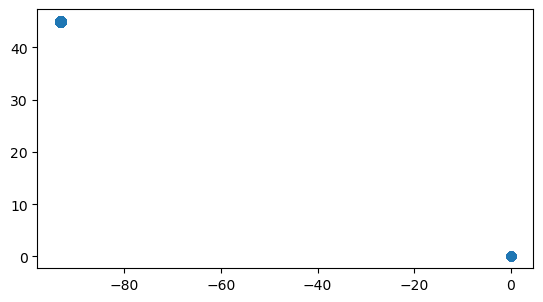

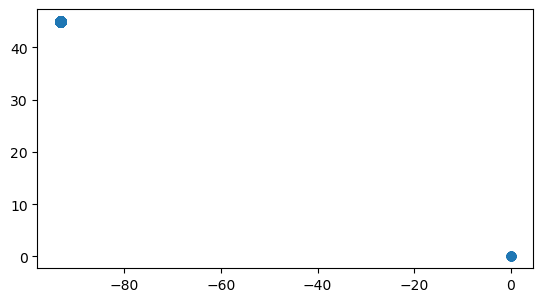

In [73]:
# read in mpls geospatial data
gdf = gpd.read_file("data/mpls/geospatial/Police_Incidents_2017.geojson")
# with pd.option_context("display.max_columns", None):
#     display(gdf)
print("Year = 2017")
gdf.plot()

gdf = gpd.read_file("data/mpls/geospatial/Police_Incidents_2018.geojson")
# with pd.option_context("display.max_columns", None):
#     display(gdf)
print("Year = 2018")
gdf["geometry"].plot()

## 3.1 Scrape weather data
We used NCEI API (https://www.ncei.noaa.gov/support/access-data-service-api-user-documentation) to get the weater data for Minneapolis. The closet weather station to Minneapolis was MSP international airport. We obtained the station ID from  HOMR database (https://www.ncei.noaa.gov/access/homr/#ncdcstnid=30131450&tab=MSHR). The station ID for MSP Airport was 72658 014922. Wit this station ID station ID we used the API to scrape Local Climatological Data. The data included useful information about weather:

1. Dry Bulb Temperature (https://en.wikipedia.org/wiki/Dry-bulb_temperature).
A Dry Bulb temperature is a temperature of air measured by a thermometer freely exposed to the air. This was later used to create useful features about daily weather.

2. Dew Point Temperature (https://en.wikipedia.org/wiki/Dew_point). Temperature to which it must be cooled to become saturated with water vapor. This was one of the metrics we used to define a "humid" day.

3. Relative Humidity (https://graphical.weather.gov/definitions/defineRH.html) the amount of atmospheric moisture present relative to the amount that would be present if the air were saturated. This was measured in percentage and higher meant more humid.


We wrote a function that uses the API to scrape weather data based on the `begin_datetime` range of the row-bound crime data. `['2010-12-25T21:59:59z', '2023-11-15T09:53:00z']`. The time zone of this data was specified UTC when scraping.

Here is an example query with the URL (click on the link if interested)
https://www.ncei.noaa.gov/access/services/data/v1?startDate=2023-01-01&endDate=2023-01-01&stations=72658014922&dataset=local-climatological-data&units=standard&formats=JSON


In [74]:
import requests
# from urllib.parse import quote

# get weather data
def get_weather(
    start_date: str = "2023-01-01",
    end_date: str = "2023-01-05",
    station_id: str = "72658014922",
    dataset: str = "local-climatological-data",
    variables = ["HourlyRelativeHumidity", "HourlyDryBulbTemperature", "HourlyDewPointTemperature"],
    units: str = "standard",
    formats: str = "JSON"
):
    # make url
    base_url = "https://www.ncei.noaa.gov/access/services/data/v1?"
    
    if type(variables) is list:
        if len(variables) == 1:
            variables = variables[0]
        elif len(variables) > 1:
            variables = ",".join(variables)
        else:
            raise Exception("length of variables is 0. Please input a variable.")
            
    elif (not type(variables) is list) & (not type(variables) is str):
        raise Exception("Invalid type for variables.")

    start_date = "startDate={}".format(start_date)
    end_date = "endDate={}".format(end_date)
    station_id = "stations={}".format(station_id)
    dataset = "dataset={}".format(dataset)
    data_type = "dataTypes={}".format(variables)
    units = "units={}".format(units)
    formats = "format={}".format(formats)

    args = "&".join([start_date, end_date, station_id, dataset, data_type, units, formats])
    
    # query_url = base_url + quote(args)
    query_url = base_url + args
    

    # query data
    r = requests.get(query_url)
    if r.status_code == 200:
        return pd.DataFrame(r.json())
    else:
        raise Exception("Status code != 200 - request was not successful. (status code: {})". format(r.status_code))


# test = get_weather()
# display(test)

### get the datetime range of the row-bound data, timezone is UTC
### we will choose the begin datetime since it seems more appropriate?
### do we care about the approximate begin datetime of the crime more or the reported datetime?
# combined_df["begin_datetime"] = pd.to_datetime(combined_df["begin_datetime"], format="ISO8601")
combined_df["begin_datetime"] = pd.to_datetime(combined_df["begin_datetime"])
date_range = [combined_df["begin_datetime"].min(), combined_df["begin_datetime"].max()]
print(list(map(lambda x: str(x), date_range)))

# fetch weather
date_range = [str(x).replace(" ", "T").replace("+00:00","z") for x in date_range]
print("date range: ", date_range)
weather_df = get_weather(start_date=date_range[0], end_date=date_range[1],
                        station_id="72658014922", dataset="local-climatological-data",
                        variables=["HourlyRelativeHumidity", "HourlyDewPointTemperature", "HourlyDryBulbTemperature"])

# export
weather_df.to_csv("MSP_weather.csv", index=False)

# before processing
display(weather_df.head())

['2010-12-25 21:59:59+00:00', '2023-11-15 09:53:00+00:00']
date range:  ['2010-12-25T21:59:59z', '2023-11-15T09:53:00z']


,HourlyDewPointTemperature,DATE,REPORT_TYPE,STATION,HourlyRelativeHumidity,SOURCE,HourlyDryBulbTemperature
0,13,2010-12-25T22:53:00,FM-15,72658014922,81,7,18
1,13,2010-12-25T23:53:00,FM-15,72658014922,81,7,18
2,NaN,2010-12-25T23:59:00,SOD,72658014922,NaN,6,NaN
3,13,2010-12-26T00:00:00,FM-12,72658014922,81,4,18
4,12,2010-12-26T00:09:00,FM-16,72658014922,79,7,18


## 3.2 Process Weather Data
### Structure of the weather data

- `DATE`: datetime in UTC, format `YYYY-MM-DDTHH:MM:SS`
- `REPORT_TYPE`: type of report. Unnecessary for our purpose
- `STATION`: 12 digit unique identifier for a weather station. We only used MSP airport station.
- `SOURCE`: unnecessary, unsure of the meaning too.
- `HourlyDryBulbTemperature`: temperature of air measure in F.
- `HourlyRelativeHumidity`: Relative humidity level in percentage. Higher means more humid.
- `HourlyDewPointTemperature`:  temperature to which it must be cooled to become saturated with water vapor. Necessary to determine what is considered a "humid" day.


From this data, we only needed 4 columns date, humidity, dew point and temperature. Using the date column, we merged the weather data to `combined_df` based on matching time stamps. The weather data and crime data's timestamps were rounded to the nearest hours to match.

We also thought `begin_datetime` of `combined_df` would be a more meaningful measure since it represented the time of when the crime actually happened. We joined the weather data based on crimes beginning datetime, not the reported date time. However, we did not drop the reported datetime in case people can make use of it in the future analysis.

After merging `combined_df` and `weather_df` there were missing temperature, dew points and humidities. We interpolated the missing data using linear interpolation (https://en.wikipedia.org/wiki/Linear_interpolation). The idea basically was to take the two points before and after the missing values, draw a straight line and calculate the mid point(s) along the lines to fill in the missing values. Before interpolation, the data was ordered by timestamps.


In [75]:
# select necessary cols only
weather_df = (weather_df[["DATE", "HourlyDewPointTemperature", "HourlyDryBulbTemperature", "HourlyRelativeHumidity"]]
                 .rename(columns={"DATE": "datetime", 
                                  "HourlyDewPointTemperature": "hourly_dewpoint", 
                                  "HourlyDryBulbTemperature": "hourly_temperature",
                                  "HourlyRelativeHumidity": "hourly_humidity"
                                 })
             )

# round to the nearest hour
weather_df["datetime"] = pd.to_datetime(weather_df["datetime"].str.replace("T", " "), utc=True)
weather_df["datetime_rounded"] = weather_df["datetime"].dt.round("H")

# combined primary data, round to the nearest hour
combined_df["datetime_rounded"] = combined_df["begin_datetime"].dt.round("H")

# merge based on rounded datetime
combined_df = pd.merge(combined_df, weather_df.rename(columns={"datetime": "weather_datetime"}), on="datetime_rounded", how="left")
# this creates duplicate columns, remove duplicates so that case numbers are unique
combined_df = combined_df.drop_duplicates(subset="case_number", ignore_index=True)


# order data by timestamps asc, interpolate missing
combined_df = combined_df.sort_values(by=["begin_datetime"], ascending=True)
combined_df["dewpoint"] = combined_df["hourly_dewpoint"].astype(float).interpolate(method="linear", limit_direction='forward').round(0)
combined_df["temperature"] = combined_df["hourly_temperature"].astype(float).interpolate(method="linear", limit_direction='forward').round(0)
combined_df["humidity"] = combined_df["hourly_humidity"].astype(float).interpolate(method="linear", limit_direction="forward").round(0)

# drop hourly columns since interpolated and thus no longer hourly
# drop rounded hours and weather timestamps
combined_df = combined_df.drop(columns=["datetime_rounded", "weather_datetime",
                                       "hourly_dewpoint", "hourly_temperature", "hourly_humidity"], axis=1)

with pd.option_context("display.max_columns", None):
    display(combined_df.head())

# export
combined_df.to_csv("combined_mpls.csv", index=False)


### get the datetime range of the row-bound data, timezone is UTC
### we will choose the begin datetime since it seems more appropriate?
### do we care about the approximate begin datetime of the crime more or the reported datetime?
# combined_df["begin_datetime"] = pd.to_datetime(combined_df["begin_datetime"], format="ISO8601")
combined_df["begin_datetime"] = pd.to_datetime(combined_df["begin_datetime"])
date_range = [combined_df["begin_datetime"].min(), combined_df["begin_datetime"].max()]
print(list(map(lambda x: str(x), date_range)))

# fetch weather
date_range = [str(x).replace(" ", "T").replace("+00:00","z") for x in date_range]
print("date range: ", date_range)
weather_df = get_weather(start_date=date_range[0], end_date=date_range[1],
                        station_id="72658014922", dataset="local-climatological-data",
                        variables=["HourlyRelativeHumidity", "HourlyDewPointTemperature", "HourlyDryBulbTemperature"])

# export
weather_df.to_csv("MSP_weather.csv", index=False)

,case_number,pub_address,reported_datetime,begin_datetime,lon,lat,precinct,neighborhood,offense,description,dewpoint,temperature,humidity
20717,MP 2017 308900,0022XX Blaisdell AV S,2017/08/15 13:30:00+00,2010-12-25 21:59:59+00:00,-93.279608,44.960009,1.0,WHITTIER,THEFT,Other Theft,NaN,NaN,NaN
3659,MP 2017 403107,0008XX Russell AV N,2017/10/19 12:14:59+00,2011-10-19 00:01:00+00:00,-93.311044,44.987001,4.0,WILLARD - HAY,CSCR,Crim Sex Cond-rape,30.0,43.0,61.0
26548,MP 2018 053408,0018XX Washington AV S,2018/02/19 15:30:00+00,2012-01-01 00:00:00+00:00,-93.246790,44.973380,1,CEDAR RIVERSIDE,CSCR,Crim Sex Cond-rape,32.0,33.0,96.0
681,MP 2017 259012,0003XX 26 AV N,2017/07/11 14:29:59+00,2012-07-01 08:00:00+00:00,-93.284153,45.005911,4.0,HAWTHORNE,CSCR,Crim Sex Cond-rape,64.0,80.0,58.0
25959,MP 2018 050110,18 ST E / Park AV S,2018/02/16 06:59:59+00,2012-08-01 18:00:00+00:00,-93.265110,44.965210,3,VENTURA VILLAGE,CSCR,Crim Sex Cond-rape,70.0,88.0,55.0


['2010-12-25 21:59:59+00:00', '2023-11-15 09:53:00+00:00']
date range:  ['2010-12-25T21:59:59z', '2023-11-15T09:53:00z']


## 4. Feature Engineering
- The columns with string values `description` and `neighborhoods` had some trailing white spaces on the right. We removed it and also lower-cased all of the characters.

Then we created some new features.

1. `crime_rating` - We categorized crimes into a numeric scale. There were about 42 unique crimes and we put thme on a scale of 1 to 10. However, some of the descriptions that are attached to the crime categories (`offense` code) were labeled differently but they meant the same. (we found this by comparing the unique counts of the two variables offense and description. i.e. `combined_df["offense"].str.rstrip(to_strip=" ").value_counts()` and `combined_df["description"].str.rstrip(to_strip=" ").str.lower().value_counts()`) Here are some examples. "automobile theft" and "motor vehicle theft" meant the same. They were coded as "AUTOTH" under offense column. The counts also summed up to "AUTOTH". i.e. automobile theft: 23,755 + motor vehicle theft: 3,003 = 26,758 which was the count for "AUTOTH". Another example is "on-line theft" and "online theft".

We combined these synonymous values under the same label in description column. Then each category of crimes were given a numeric rating on a scale of 1 to 10, 10 being the most severe. 


2. `is_violent`: We also categorized crimes based on their violence. Some crimes involving physical harm or pose a threat to physical well-being were categorized as voilent.

Here is a table summarizing the categorization

| Offense code  | description                          | count  | rating  | Is_violent  |
|---------------|--------------------------------------|--------|---------|-------------|
| AUTOTH        | automobile theft                     | 26758  | 5       | No          |
| THEFT         | other theft                          | 26714  | 4       | No          |
| TFMV          | theft from motor vehicle             | 23263  | 5       | No          |
| BURGD         | burglary of dwelling                 | 13359  | 7       | No          |
| TMVP          | theft-motor vehicle parts            | 9439   | 5       | No          |
| ASLT2         | assault with dangerous weapon        | 6602   | 8       | Yes         |
| BIKETF        | bike theft                           | 6596   | 3       | No          |
| BURGB         | burglary of business                 | 6100   | 6       | No          |
| ROBPAG        | robbery per agg                      | 4849   | 7       | Yes         |
| SHOPLF        | shoplifting                          | 4480   | 2       | No          |
| ROBPER        | robbery of person                    | 3379   | 7       | Yes         |
| DASLT2        | 2nd degree domestic assault          | 2412   | 6       | Yes         |
| THFTSW        | theft by swindle                     | 2372   | 4       | No          |
| DASTR         | domestic assault/strangulation       | 2272   | 8       | Yes         |
| CSCR          | crime sexual conduct-rape            | 2175   | 10      | Yes         |
| CARJCK        | robbery including auto theft         | 1601   | 5       | No          |
| TFPER         | theft from person snatch/grab        | 1422   | 6       | Yes         |
| ASLT3         | assault-significant bodily harm      | 1047   | 8       | Yes         |
| TBLDG         | theft from building                  | 731    | 5       | No          |
| ROBBIZ        | robbery of business                  | 727    | 6       | Yes         |
| ASLT4         | assault4-substantial harm or weapon  | 642    | 7       | Yes         |
| ARSON         | arson                                | 634    | 6       | Yes         |
| DASLT3        | 3rd degree domestic assault          | 428    | 5       | Yes         |
| MURDR         | murder (general)                     | 380    | 10      | Yes         |
| MVTHFT        | other vehicle theft                  | 176    | 5       | No          |
| ONLTHT        | online theft                         | 143    | 4       | No          |
| ASLT1         | assault-great bodily harm            | 114    | 9       | Yes         |
| WLKOFF        | fail to pay - taxi/hotel/rest        | 107    | 2       | No          |
| ADLTTN        | adulteration                         | 56     | 4       | No          |
| COMPUT        | hacking/theft by computer            | 40     | 6       | No          |
| POCKET        | pocket-picking                       | 34     | 3       | No          |
| PETIT         | petty theft                          | 28     | 2       | No          |
| NOPAY         | gas station drive-off                | 18     | 1       | No          |
| DASLT1        | 1st degree domestic assault          | 15     | 7       | Yes         |
| COINOP        | theft/coinop device                  | 14     | 3       | No          |
| SCRAP         | scrapping-recycling theft            | 11     | 4       | No          |
| DISARM        | disarm a police officer              | 7      | 7       | Yes         |
| ABSVAR        | rape - vulnerable adult              | 6      | 10      | Yes         |
| PKGTHEFT      | package theft                        | 3      | 3       | No          |
| LOOT          | looting                              | 3      | 5       | No          |
| JHOMIC        | justifiable homicide                 | 3      | 5       | Yes         |


3. `is_dangerous`: we wanted to see what neighborhoods are considered dangerous. We defined a dangerous neighborhood as having an average crime rating greater than or equal to 5.5. We chose our cutoff point as 5.5 because the overall average crime rating was about 5.29 and we wanted to make the threshold a little harsher than average but still close to the mean.

We first create a separate dataframe that shows average crime rating by neighborhood, then we create a feature in that df flagging if a neighborhood is dangerous or not. Then we join this data frame back to our original data.

4. `daily_avg_humidity`, `daily_avg_dewpoint`, `daily_avg_temperature`: The data was grouped by dates and daily temperature, humidity and dew points were calculated. We created a separate data frame with daily aggregated averages and joined the averaged back to the original data frame based on matching dates.

5. `is_hot`, `is_humid`: We wanted to create flag columns indicating if a day was hot or humid. For a hot day, anything above 85 F was considere hot. For humidity there was not a simple definition as the concept of humidity was relative. We found an article summarizing some useful info when defining a "humid" day (included below). What we learned was that we had to look at both dew point temperature and relative humidity. if relative humidity was above 50% and the dew point was above 65 degrees then it was considered a humid day.

- dew point above 65 degrees in the summer is considered humid (https://www.weather.gov/arx/why_dewpoint_vs_humidity#:~:text=For%20example%2C%20a%20temperature%20of,with%20a%20100%25%20relative%20humidity)
- relatve humidity greater than 50% is humid (https://science.howstuffworks.com/environmental/earth/geophysics/h2o.html)

6. `d2_nearest_police_station`: we wanted to calculate the distance to the nearest police station for a crime record. 

We imported the police station geospatial data for Heneppin county. We chose all of the hennepin county police station because for some crime locations police stations in other cities (brooklyn park, roseville, etc.) might be closer to the police stations in minneapolice.

Then we calculate the circular distance (https://en.wikipedia.org/wiki/Great-circle_distance) from crime location to all of the police stations in the dataset. Then we find the minimum distance and assign that to the column `d2nearest_police_station`. we also assign the name of the police station to a column `nearest_police_station`. we use haversine formula to do so.

## 4.1 Crime Rating

In [76]:
# export the counts for comparison
# combined_df["offense"].str.rstrip(to_strip=" ").value_counts().to_csv("offense_counts.csv")
# combined_df["description"].str.rstrip(to_strip=" ").str.lower().value_counts().to_csv("offense_desc_counts.csv")

### crime rating

# strip trailing white space and lowercase
combined_df["offense"] = combined_df["offense"].str.rstrip(to_strip=" ")
combined_df["description"] = combined_df["description"].str.rstrip(to_strip=" ").str.lower()
## re-label description column
conds = [
    combined_df["description"] == "theft from motr vehc",
    combined_df["description"] == "theft-motr veh parts",
    combined_df["description"] == "asslt w/dngrs weapon",
    combined_df["description"] == "motor vehicle theft",
    combined_df["description"] == "2nd deg domes aslt",
    (combined_df["description"] == "csc - rape") | (combined_df["description"] == "crim sex cond-rape"),
    combined_df["description"] == "aslt-sgnfcnt bdly hm",
    combined_df["description"] == "aslt4-less than subst harm",
    combined_df["description"] == "3rd deg domes aslt",
    combined_df["description"] == "theft from person",
    combined_df["description"] == "csc - sodomy",
    (combined_df["description"] == "aslt-police/emerg p") | (combined_df["description"] == "obs - aslt-police/emerg p"),
    combined_df["description"] == "aslt-great bodily hm",
    combined_df["description"] == "csc - penetrate with object",
    combined_df["description"] == "on-line theft",
    combined_df["description"] == "trespassed - burg buisiness",
    combined_df["description"] == "aslt4-subst harm or weapon",
    combined_df["description"] == "obs - petty theft",
    combined_df["description"] == "gas station driv-off",
    (combined_df["description"] == "1st deg domes aslt") | (combined_df["description"] == "1st deg domes asslt"),
    combined_df["description"] == "obs - computer hacking",
    combined_df["description"] == "do not use"
]

choices = [
    "theft from motor vehicle", 
    "theft-motor vehicle parts",
    "assault with dangerous weapon",
    "automobile theft",
    "2nd degree domestic assault",
    "crime sexual conduct-rape",
    "assault-significant bodily harm",
    "assault4-less than substantial harm",
    "3rd degree domestic assault",
    "theft from person snatch/grab",
    "crime sexual conduct-sodomy",
    "assault-police/emergency personnel",
    "assault-great bodily harm",
    "crime sexual conduct-penetrate with object",
    "online theft",
    "burglary of business",
    "assault4-substantial harm or weapon",
    "petty theft",
    "gas station drive-off",
    "1st degree domestic assault",
    "computer hacking",
    "package theft"
]

combined_df["description"] = np.select(conds, choices, default=combined_df["description"])

### add crime rating
conds = [
    combined_df["offense"] == "NOPAY",
    combined_df["offense"].isin(["PETIT", "SHOPLF", "WLKOFF"]),
    combined_df["offense"].isin(["BIKETF", "POCKET", "COINOP", "PKGTHEFT"]),
    combined_df["offense"].isin(["THEFT", "THFTSW", "ONLTHT", "ADLTTN", "SCRAP"]),
    combined_df["offense"].isin(["AUTOTH", "TFMV", "TMVP", "CARJCK", "TBLDG", "DASLT3", "MVTHFT", "LOOT", "JHOMIC"]),
    combined_df["offense"].isin(["BURGB", "DASLT2", "TFPER", "ROBBIZ", "ARSON", "COMPUT"]),
    combined_df["offense"].isin(["BURGD", "ROBPAG", "ROBPER", "ASLT4", "DASLT1", "DISARM"]),
    combined_df["offense"].isin(["ASLT2", "DASTR", "ASLT3"]),
    combined_df["offense"] == "ASLT1",
    combined_df["offense"].isin(["CSCR", "MURDR", "ABSVAR"])
]

choices = list(range(1, 11))

combined_df["crime_rating"] = np.select(conds, choices, default=np.nan)

# display(combined_df.head())


# export
# combined_df.to_csv("combined_mpls.csv", index=False)

## 4.2 Was it a Violent Crime?

In [77]:
# is violent crime?
violent_list = ["ASLT2", "ROBPAG", "ROBPER", "DASLT2", "DASTR", "CSCR", "TFPER", "ASLT3", "ROBBIZ", "ASLT4", "ARSON", "DASLT3",
                "MURDR", "ASLT1", "DASLT1", "DISARM", "ABSVAR", "JHOMIC"]
combined_df["is_violent"] = np.where(combined_df["offense"].isin(violent_list), "violent", "not violent")

# export
# combined_df.to_csv("combined_mpls.csv", index=False)

## 4.3  Is it a dangerous neighborhood? 

In [78]:
# is dangerous neighborhood?
print("Overall average crime rating:", combined_df["crime_rating"].mean())
combined_df["neighborhood"] = combined_df["neighborhood"].str.rstrip(to_strip=" ").str.lower()
avg_rating = (combined_df
                  .groupby(by="neighborhood", as_index=False)
                  .agg({"crime_rating":"mean"})
                  .rename(columns={"crime_rating":"avg_crime_rating"})
             )

avg_rating["is_dangerous"] = np.where(avg_rating["avg_crime_rating"] >= 5.5, "dangerous", "safe")

display(avg_rating)

# join data
combined_df = pd.merge(combined_df, avg_rating, on="neighborhood", how="left").drop("avg_crime_rating", axis=1)

# display(combined_df)
# combined_df.info()

# export
# avg_rating.to_csv("neighborhood_crime_rating.csv", index=False)
# combined_df.to_csv("combined_mpls.csv", index=False)

Overall average crime rating: 5.283950120675784


,neighborhood,avg_crime_rating,is_dangerous
0,armatage,5.396304,safe
1,audubon park,5.435115,safe
2,bancroft,5.436137,safe
3,beltrami,5.216359,safe
4,bottineau,5.336502,safe
...,...,...,...
86,west maka ska,5.009585,safe
87,whittier,5.223046,safe
88,willard - hay,5.827560,dangerous
89,windom,5.215503,safe


## 4.4 Daily Average Weather Metrics

In [79]:
# calculate daily averages for humidity and temperature
combined_df["date"] = combined_df["begin_datetime"].dt.date
daily_avg = (combined_df
                 .groupby(by="date", as_index=False)
                 .agg({'dewpoint':'mean', 'temperature':'mean', "humidity":"mean"})
                 .rename(columns={"dewpoint":"daily_avg_dewpoint", "temperature":"daily_avg_temperature", "humidity":"daily_avg_humidity"})
            )

combined_df = pd.merge(combined_df, daily_avg, on="date", how="left").drop("date", axis=1)

# export
# combined_df.to_csv("combined_mpls.csv", index=False)

## 4.5 Was it a hot/humid day?

In [80]:
# high humidity or high temperature, i.e. is hot day and is humid day
combined_df["is_hot"] = np.where(combined_df["daily_avg_temperature"] >= 85, 
                                 "hot", "not hot")
combined_df["is_humid"] = np.where((combined_df["daily_avg_dewpoint"] > 65) & (combined_df["daily_avg_humidity"] > 50), 
                                   "humid", "not humid")

## 4.6 Distance to Nearest Police Station

EPSG:4326


,OBJECTID,NAME,TELEPHONE,ADDRESS,CITY,ZIP,WEB_URL,USNG,GlobalID,geometry
0,1,Bloomington Police Department,952-563-4900,1800 West Old Shakopee Road,Bloomington,55431,http://www.ci.bloomington.mn.us/,15TVK7648263274,{0048981A-89AF-4237-A1FD-4A4188C80381},POINT (-93.30232 44.82519)
1,2,Brooklyn Center Police Department,763-569-3333,6645 Humbolt Ave North,Brooklyn Center,55430,http://www.ci.brooklyn-center.mn.us/,15TVK7660791374,{D05D1A7F-DAAF-414C-A7F8-28EC4AFB83CD},POINT (-93.30058 45.07695)
2,3,Brooklyn Park Police Department,763-493-8222,5400 85th Avenue North,Brooklyn Park,55443,http://www.brooklynpark.org/,15TVK7261195076,{D99AD987-FBDC-48CD-8501-13BAC67505BD},POINT (-93.34977 45.10996)
3,4,Champlin Police Department,763-421-2971,11955 Champlin Drive,Champlin,55316,http://ci.champlin.mn.us/,15TVL6906802007,{42F2F525-708D-4D0A-BCF1-D9D11EF22058},POINT (-93.39455 45.17177)
4,5,Corcoran Police Department,763-525-6220,8200 County Road 116,Corcoran,55340,http://www.ci.corcoran.mn.us/,15TVK5753094434,{3E50A82C-DAD1-41C0-9734-EE0612D2A30A},POINT (-93.54206 45.10316)


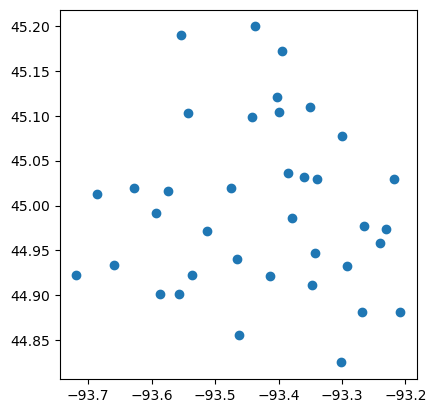

In [81]:
police_df = gpd.read_file("data/mpls/geospatial/Police_Stations.geojson")
# police_df has crs = EPSG:4326
print(police_df.crs)
display(police_df.head())
police_df.plot()

# extract lon, lat from geometry
police_df["lon"] = police_df["geometry"].x
police_df["lat"] = police_df["geometry"].y

In [82]:
# haversine formula to get the distance
def haversine(row, lon2, lat2):
    """
    returns the great circular distance in miles
    row: row of data frame with lon/lat
    lon2: insert one longitude to calculate distance against the row
    lat2: insert one latitude to calculate distance agains the row
    """
    lon1 = row['lon']
    lat1 = row['lat']
    lon1, lat1, lon2, lat2 = np.radians([lon1, lat1, lon1, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    miles = 3956 * c
    return miles

# calculate circular distance
for i in range(len(police_df)):
    combined_df[f'distance_{i}'] = combined_df.apply(lambda row: haversine(row, police_df["lon"][i], police_df["lat"][i]), axis=1)
 

# find the nearest (i.e. mininum) distance
combined_df["d2nearest_police_station"] = combined_df.filter(regex=("distance_\d+")).min(axis=1)
combined_df["min_col_idx"] = combined_df.filter(regex="distance_\d+").idxmin(axis=1).str.replace("distance_","").astype(int)

# drop all unnecessary cols
combined_df = combined_df.drop(list(combined_df.filter(regex="^distance_\d+")), axis=1)

# copy over the police station name using merge
combined_df = pd.merge(combined_df, 
         police_df[["OBJECTID", "NAME"]].rename(columns={"OBJECTID":"min_col_idx", "NAME":"nearest_police_station"}), 
         on="min_col_idx", 
         how="left").drop("min_col_idx", axis=1)

# combined_df.info()
# display(combined_df)
# export
# combined_df.to_csv("combined_mpls.csv", index=False)

# The Final Data

In [86]:
combined_df.info()
with pd.option_context("display.max_columns", None):
    display(combined_df)
# export
combined_df.to_csv("combined_mpls.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149160 entries, 0 to 149159
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   case_number               149160 non-null  object             
 1   pub_address               149160 non-null  object             
 2   reported_datetime         149160 non-null  object             
 3   begin_datetime            149160 non-null  datetime64[ns, UTC]
 4   lon                       149160 non-null  float64            
 5   lat                       149160 non-null  float64            
 6   precinct                  149119 non-null  object             
 7   neighborhood              148812 non-null  object             
 8   offense                   149160 non-null  object             
 9   description               149160 non-null  object             
 10  dewpoint                  149159 non-null  float64            
 11  

,case_number,pub_address,reported_datetime,begin_datetime,lon,lat,precinct,neighborhood,offense,description,dewpoint,temperature,humidity,crime_rating,is_violent,is_dangerous,daily_avg_dewpoint,daily_avg_temperature,daily_avg_humidity,is_hot,is_humid,d2nearest_police_station,nearest_police_station
0,MP 2017 308900,0022XX Blaisdell AV S,2017/08/15 13:30:00+00,2010-12-25 21:59:59+00:00,-93.279608,44.960009,1.0,whittier,THEFT,other theft,NaN,NaN,NaN,4.0,not violent,safe,NaN,NaN,NaN,not hot,not humid,0.112751,Medina Police Department
1,MP 2017 403107,0008XX Russell AV N,2017/10/19 12:14:59+00,2011-10-19 00:01:00+00:00,-93.311044,44.987001,4.0,willard - hay,CSCR,crime sexual conduct-rape,30.0,43.0,61.0,10.0,violent,dangerous,30.000000,43.000000,61.000000,not hot,not humid,0.047196,Edina Police Department
2,MP 2018 053408,0018XX Washington AV S,2018/02/19 15:30:00+00,2012-01-01 00:00:00+00:00,-93.246790,44.973380,1,cedar riverside,CSCR,crime sexual conduct-rape,32.0,33.0,96.0,10.0,violent,safe,32.000000,33.000000,96.000000,not hot,not humid,0.037674,Three Rivers Park District Police
3,MP 2017 259012,0003XX 26 AV N,2017/07/11 14:29:59+00,2012-07-01 08:00:00+00:00,-93.284153,45.005911,4.0,hawthorne,CSCR,crime sexual conduct-rape,64.0,80.0,58.0,10.0,violent,dangerous,64.000000,80.000000,58.000000,not hot,not humid,0.455348,Wayzata Police Department
4,MP 2018 050110,18 ST E / Park AV S,2018/02/16 06:59:59+00,2012-08-01 18:00:00+00:00,-93.265110,44.965210,3,ventura village,CSCR,crime sexual conduct-rape,70.0,88.0,55.0,10.0,violent,dangerous,70.000000,88.000000,55.000000,hot,humid,0.426991,University of Minnesota Police
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149155,MP2023305602,0025XX 2ND ST NE,2023/11/14 23:37:00+00,2023-11-14 23:00:00+00:00,-93.266200,45.014070,2,marshall terrace,AUTOTH,automobile theft,38.0,55.0,53.0,5.0,not violent,safe,33.965517,60.034483,37.965517,not hot,not humid,0.107980,Wayzata Police Department
149156,MP2023305744,0006XX KENWOOD PKWY,2023/11/15 09:43:00+00,2023-11-15 01:57:00+00:00,-93.296050,44.969470,5,lowry hill,BURGB,burglary of business,38.0,47.0,71.0,6.0,not violent,safe,34.500000,43.500000,71.250000,not hot,not humid,0.132858,University of Minnesota Police
149157,MP2023305718,0027XX PLEASANT AVE,2023/11/15 06:01:00+00,2023-11-15 05:30:00+00:00,-93.282980,44.952840,5,whittier,BURGB,burglary of business,33.0,39.0,79.0,6.0,not violent,safe,34.500000,43.500000,71.250000,not hot,not humid,0.382227,Medina Police Department
149158,MP2023305743,0024XX STEVENS AVE,2023/11/15 11:17:00+00,2023-11-15 06:32:00+00:00,-93.275300,44.958260,5,whittier,AUTOTH,automobile theft,33.0,40.0,77.0,5.0,not violent,safe,34.500000,43.500000,71.250000,not hot,not humid,0.008001,Medina Police Department


## 5. Combine Geospatial Crime Data.

We still had the raw yearly geospatil data to combine. Since we have already created the necessary features and completed the data cleaning, our interest in this data were the geometry column (point/coordinates of the crime). We took `geometry` column from the data and merged it with the combined crime data from above. The resulting objects were geo-data frames. 
<!-- 
With this in mind, we still combine the geospatial data and concatenate them?
I know that geopandas works with shp files and it not only reads the shp files but also the other files in the same directory.
when exporting, does it really make sense to export as one shp file and still have to plot capability?

Also when joining pd dataframe and gpd geodataframes, the plotting capability seems to get lost?

maybe work with geojson?

geojson has the same file structures and it makes more sense to export as one geojson, overall easier

think of which file format should be the final output - I think it makes the most sense to output as a geojson object 
couple reasons to consider -

1. shape files - these are stored in a zipped folder and when you read in (e.g. `gpd.read_file("data/mpls/geospatial/Police_Incidents_2023.zip")`), you are actually reading in the other files in the zipped folder too. You are not just using the shape files.
2. our data consisted of multiple years and we can use `gpd.concat` to row-bind the geo data frames to have a consolidated version from 2017 to 2023. However, when exporting there are some complications. If we just export that shape file alone, it is not really useful because we also need all the other files to correctly read in the geospatial data. So we decided to move away from this
3. On the other hand, geojson files are single file, you can read in with `gpd.read_file` normally and `gpd.concat` or row-bind the different year data with no problem. The resulting dataframe can be exported as one geojson file. This avoids complexity of having multiple different types of files in a zipped directory (.shp, ...,etc)


Other notes - 2017 and 2018 data has data quality issues. the geometry (lon, lat) do not seem to be correct. There are only two points in the plot when we plotted the data.

we were aware of this issue but for this project we did not discard the data. The locations of the crime might be wrong but we thought other information is still useful. 

However, this data quality issue affects the distance to police station problem.





Another interesting point we thought was that geojson files have almost identical columns with its primary dataset counterpart (the csv files). i.e. there were case number, datetime, offense, description,...,etc in all of the geospatial data as well. one difference was that the geospatial data had column `geometry` to be used for plotting and other stuff.

So we were thinking about which format of our final data is going to be. 
1. Should the final data be csv files with all of the non-geopspatial attributes? and have one combined geojson file with ONLY the ID (case number) and geometry, to be used with supplementary to the primary csv file?
2. or we can have one final geojson file with all of the non-geospatial attributes from our primary csv file as well as the geometry column.

For the geojson files we only care about the case number and geometry, all other attributes are already in the primary dataset we combined. -->

In [84]:
#### read all geojson and row-bind them
## we only take the necessary columns - case number and geometry. We have all of the other necessary attributed in the combined primary dataset
gdf_dict = {"file":[], "geo_dataframe":[]}

for y in range(2017, 2024):
    path = f"data/mpls/geospatial/Police_Incidents_{y}.geojson"
    gdf = gpd.read_file(path)

    # subset columns
    if "CCN" in gdf.columns:
        gdf = gdf[["CCN", "geometry"]].rename(columns={"CCN": "case_number"})
    elif "caseNumber" in gdf.columns:
        gdf = gdf[["caseNumber", "geometry"]].rename(columns={"caseNumber": "case_number"})
    
    # save result
    gdf_dict["file"].append(path)
    gdf_dict["geo_dataframe"].append(gdf)

# combine geo dataframe
combined_gdf = pd.concat(gdf_dict["geo_dataframe"], ignore_index=True)

# now perform attribute joins - we can add the columns from combined_df the primary dataset
combined_gdf = combined_gdf.merge(combined_df, on="case_number")

print(combined_gdf.crs)
# EPSG:4326

display(combined_gdf)
combined_gdf.info()
# export
combined_gdf.to_file("combined_mpls.geojson", driver="GeoJSON")

EPSG:4326


,case_number,geometry,pub_address,reported_datetime,begin_datetime,lon,lat,precinct,neighborhood,offense,...,crime_rating,is_violent,is_dangerous,daily_avg_dewpoint,daily_avg_temperature,daily_avg_humidity,is_hot,is_humid,d2nearest_police_station,nearest_police_station
0,MP 2017 292070,POINT (-93.29432 45.00685),0026XX Emerson AV N,2017/08/02 19:30:00+00,2017-07-28 15:00:00+00:00,-93.294315,45.006850,4.0,hawthorne,AUTOTH,...,5.0,not violent,dangerous,58.070423,76.028169,55.028169,not hot,not humid,0.390548,Wayzata Police Department
1,MP 2017 292852,POINT (-93.29563 45.02308),0037XX Fremont AV N,2017/08/03 10:34:00+00,2017-08-02 22:30:00+00:00,-93.295628,45.023080,4.0,folwell,THEFT,...,4.0,not violent,dangerous,56.803030,74.833333,54.409091,not hot,not humid,0.227168,Saint Louis Park Police Department
2,MP 2017 294006,POINT (-93.29559 45.01224),0030XX Fremont AV N,2017/08/04 10:20:00+00,2017-08-04 08:00:00+00:00,-93.295587,45.012237,4.0,jordan,ROBPAG,...,7.0,violent,dangerous,50.961039,70.168831,52.337662,not hot,not humid,0.018569,Wayzata Police Department
3,MP 2017 294672,POINT (-93.25186 44.94837),0015XX Lake ST E,2017/08/04 18:48:00+00,2017-08-04 18:13:00+00:00,-93.251864,44.948367,3.0,east phillips,SHOPLF,...,2.0,not violent,dangerous,50.961039,70.168831,52.337662,not hot,not humid,0.088846,Minnetrista Police Department
4,MP 2017 294754,POINT (-93.30950 44.99423),0015XX Queen AV N,2017/08/04 19:28:00+00,2017-07-26 00:00:00+00:00,-93.309498,44.994233,4.0,willard - hay,THEFT,...,4.0,not violent,dangerous,65.228571,77.128571,68.628571,not hot,humid,0.211036,MSP International Airport Police
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149155,MP2023700579,POINT (-93.29704 44.94566),0031XX GIRARD AVE S,2023/01/17 11:59:00+00,2023-01-14 00:50:00+00:00,-93.297040,44.945660,5,south uptown,TMVP,...,5.0,not violent,safe,18.945455,24.872727,78.727273,not hot,not humid,0.098064,Minnetrista Police Department
149156,MP2023700580,POINT (-93.27087 44.95732),0003XX 25TH ST E,2023/01/17 11:59:00+00,2023-01-16 17:00:00+00:00,-93.270870,44.957320,5,whittier,TMVP,...,5.0,not violent,safe,31.512195,33.817073,91.768293,not hot,not humid,0.072904,Medina Police Department
149157,MP2023700582,POINT (-93.27524 44.98816),0007XX 2ND ST N,2023/01/17 12:08:00+00,2023-01-13 23:55:00+00:00,-93.275240,44.988160,1,north loop,TFMV,...,5.0,not violent,safe,14.205128,17.846154,85.628205,not hot,not humid,0.127194,Edina Police Department
149158,MP2023700584,POINT (-93.30506 44.99875),0019XX GOLDEN VALLEY RD,2023/01/17 12:15:00+00,2023-01-04 09:30:00+00:00,-93.305060,44.998750,4,jordan,THEFT,...,4.0,not violent,dangerous,29.214286,31.357143,91.482143,not hot,not humid,0.522904,MSP International Airport Police


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 149160 entries, 0 to 149159
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   case_number               149160 non-null  object             
 1   geometry                  149160 non-null  geometry           
 2   pub_address               149160 non-null  object             
 3   reported_datetime         149160 non-null  object             
 4   begin_datetime            149160 non-null  datetime64[ns, UTC]
 5   lon                       149160 non-null  float64            
 6   lat                       149160 non-null  float64            
 7   precinct                  149119 non-null  object             
 8   neighborhood              148812 non-null  object             
 9   offense                   149160 non-null  object             
 10  description               149160 non-null  object           

## Example use case

1. Find the location of violent crimes. We can use the `lon`, `lat` and `is_violent` columns to find the locations of violent crimes
2. We can also find the locations of dangerous neighborhood. We merge the neighborhoods data with combined data. In doing so we only copy `is_dangerous` column from the combined primary crime dataset.

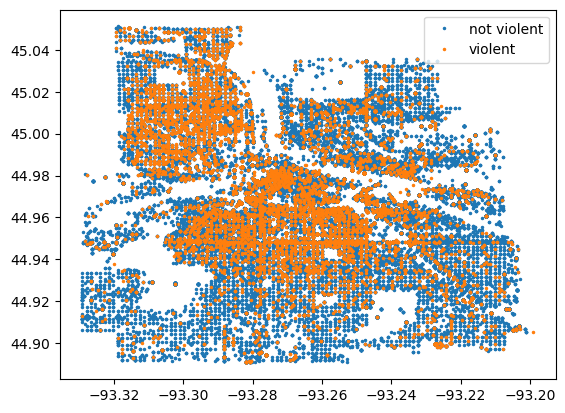

<Axes: >

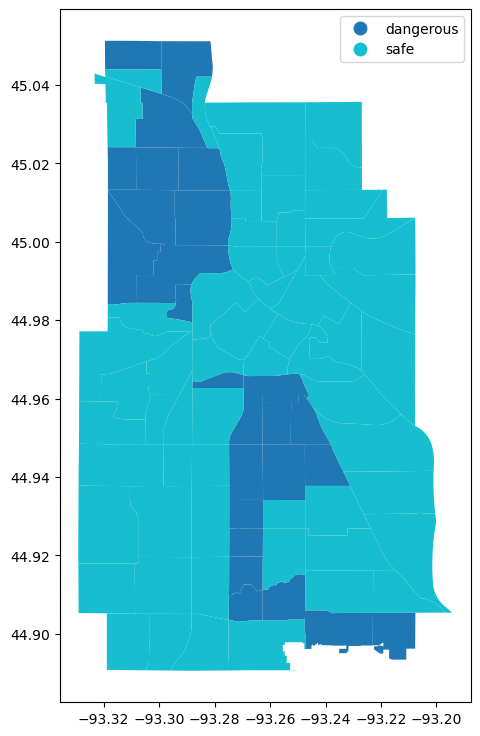

In [85]:
import matplotlib.pyplot as plt

# plot violent crime locations
groups = combined_df[combined_df['begin_datetime'].dt.year > 2018].groupby("is_violent")
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.lon, group.lat, marker='o', linestyle='', ms=1.5, label=name)
ax.legend()
plt.show()


# dangerous neighborhoods
n_gdf = gpd.read_file("data/mpls/geospatial/Minneapolis_Neighborhoods.zip")
n_gdf["neighborhood"] = n_gdf["BDNAME"].str.rstrip(to_strip=" ").str.lower()
combined_ngdf = n_gdf[["neighborhood", "geometry"]].merge(combined_df[["neighborhood", "is_dangerous"]].drop_duplicates(), 
                                                          on="neighborhood", how="left")

combined_ngdf.plot(figsize=(9,9), column="is_dangerous", legend=True)

In [87]:
!jupyter nbconvert --to html process_data_mpls.ipynb

[NbConvertApp] Converting notebook process_data_mpls.ipynb to html
[NbConvertApp] Writing 794485 bytes to process_data_mpls.html
